In [2]:
# Import necessary dependencies
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback, LambdaCallback, TensorBoard, EarlyStopping
from keras.utils.layer_utils import print_summary
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Check package versions
print(tf.__version__)
print(keras.__version__)

1.9.0
2.2.4


In [4]:
# Load data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [5]:
# Check data shape
print(type(X_train), X_train.shape)
print(type(Y_train), Y_train.shape)
print(type(X_test), X_test.shape)
print(type(Y_test), Y_test.shape)

<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000,)
<class 'numpy.ndarray'> (10000, 28, 28)
<class 'numpy.ndarray'> (10000,)


In [6]:
# Flatten 28*28 images to a 784 vector for each image
n_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], n_pixels).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], n_pixels).astype(np.float32)
print(type(X_train), X_train.shape)
print(type(X_test), X_test.shape)

<class 'numpy.ndarray'> (60000, 784)
<class 'numpy.ndarray'> (10000, 784)


In [7]:
# Normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [8]:
# One hot encode outputs
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
print(type(Y_train), Y_train.shape)
print(type(Y_test), Y_test.shape)

<class 'numpy.ndarray'> (60000, 10)
<class 'numpy.ndarray'> (10000, 10)


In [9]:
n_classes = Y_test.shape[1]
print(n_classes)

10


In [10]:
# Reset the graph
tf.reset_default_graph()

In [11]:
# Build the NN model
inputs = Input(shape=(n_pixels, ), name='input')
with tf.name_scope('layer-1'):
    X = Dense(500, kernel_initializer='normal', activation='relu', name='H1')(inputs)
    X = Dropout(0.5, name='DO1')(X)
with tf.name_scope('layer-2'):
    X = Dense(300, kernel_initializer='normal', activation='relu', name='H2')(X)
    X = Dropout(0.5, name='DO2')(X)
with tf.name_scope('output'):
    X = Dense(n_classes, kernel_initializer='normal', activation='softmax', name='output')(X)

model = Model(inputs=inputs, outputs=X)

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
H1 (Dense)                   (None, 500)               392500    
_________________________________________________________________
DO1 (Dropout)                (None, 500)               0         
_________________________________________________________________
H2 (Dense)                   (None, 300)               150300    
_________________________________________________________________
DO2 (Dropout)                (None, 300)               0         
_________________________________________________________________
output (Dense)               (None, 10)                3010      
Total params: 545,810
Trainable params: 545,810
Non-trainable params: 0
_________________________________________________________________
None

In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Define my own history callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = {'batch': [], 'epoch': []}
        self.acc = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}
    
    def on_batch_end(self, batch, logs={}):
        self.loss['batch'].append(logs.get('loss'))
        self.acc['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    
    def on_epoch_end(self, batch, logs={}):
        self.loss['epoch'].append(logs.get('loss'))
        self.acc['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
        
    def loss_plot(self, loss_type):
        iters = np.arange(len(self.loss[loss_type]))
        # acc
        plt.figure(1)
        plt.plot(iters, self.acc[loss_type], 'r', label='train acc')
        # loss
        plt.figure(2)
        plt.plot(iters, self.loss[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.figure(1)
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.figure(2)
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        
        plt.figure(1)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="upper right") 
        
        plt.figure(2)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc="upper right")      

In [23]:
history = LossHistory()

In [30]:
# Define another callback
class MyCallback(Callback):
    def __init__(self, test_data, test_label, log_file=None, verbose=True):
        self.test_data = test_data
        self.test_label = test_label
        self.result = []
        self.log = open(log_file, "w") if log_file else None
        self.verbose = verbose
        
    def on_epoch_end(self, epoch, logs=None):
        probs = self.model.predict(self.test_data)
        
        def cal_acc(probs, test_label):
            acc = np.mean(np.equal(np.argmax(probs, axis=1), np.argmax(test_label, axis=1)).astype(np.float32), axis=0)
            return acc
        
        avg_acc = cal_acc(probs, self.test_label)
        self.result.append(avg_acc)
        log_str = 'Epoch {}, acc: {:.4f}'.format(epoch, avg_acc)
        if self.verbose:
            print(log_str)
        if self.log:
            print(log_str, file=self.log)
        
    def on_train_end(self, logs=None):
        if self.log:
            self.log.close()

In [31]:
log_file = "logs/log.txt"
my_callback = MyCallback(X_test, Y_test, log_file=log_file, verbose=True) 

In [32]:
# Fit the model
model_history = model.fit(
    X_train, Y_train, batch_size=256, epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[history, my_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0119 - acc: 0.9966 - val_loss: 0.0839 - val_acc: 0.9868
Epoch 0, acc: 0.9868
Epoch 2/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.0137 - acc: 0.9962 - val_loss: 0.0838 - val_acc: 0.9859
Epoch 1, acc: 0.9859
Epoch 3/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.0113 - acc: 0.9965 - val_loss: 0.0839 - val_acc: 0.9850
Epoch 2, acc: 0.9850
Epoch 4/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0121 - acc: 0.9965 - val_loss: 0.0798 - val_acc: 0.9867
Epoch 3, acc: 0.9867
Epoch 5/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0127 - acc: 0.9963 - val_loss: 0.0797 - val_acc: 0.9876
Epoch 4, acc: 0.9876
Epoch 6/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0138 - acc: 0.9962 - val_loss: 0.0782 - val_acc: 0.9871
Epoch 5, acc: 0.9871
Ep

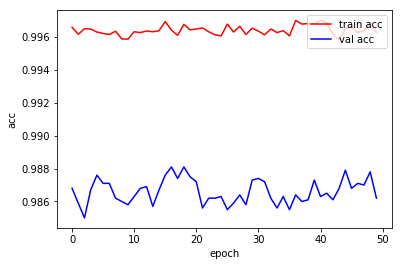

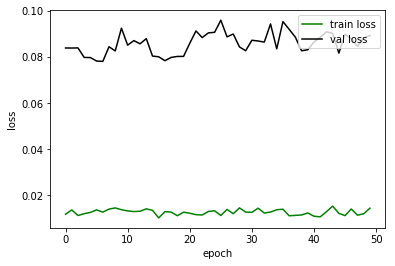

In [33]:
history.loss_plot('epoch')

In [34]:
# Evaluate the model
score = model.evaluate(X_test, Y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

10000/10000 [==============================] - 0s 29us/step
Test loss:  0.08924511419710725
Test accuracy:  0.9862
